In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import obspy.core as oc

from dasn2n import dasn2n # DAS-N2N model (torch version)

## Running DAS-N2N model

In [2]:
# Load DAS-N2N model and load pre-trained weights from paper
pretrained_model = dasn2n()
pretrained_model.load_weights("original.pt")

In [3]:
pretrained_model.eval() # Set model to evaluation mode (as opposed to train mode)

dasn2n(
  (conv00): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv01a): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv01b): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out01): Conv2d(48, 1, kernel_size=(1, 1), stride=(1, 1))
  (act): LeakyReLU(negative_slope=0.1)
  (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=nearest)
)

In [4]:
# Read example data from GitHub (stored as mseed for convenience):
das_data_mseed = oc.read("../DAS-N2N-main/data/BPT1_UTC_20200117_013019.232.mseed")

In [5]:
das_data_numpy = np.zeros((len(das_data_mseed[0].data), len(das_data_mseed))) # (Time samples, DAS channels)
n = 0
for das_channel in das_data_mseed:
    das_data_numpy[:,n] = das_channel.data
    n += 1

In [6]:
das_data_numpy

array([[-464., -408., -299., ...,   41.,   35.,   27.],
       [ 113.,  102.,   46., ...,  -64.,  -36.,  -28.],
       [-115., -118., -121., ...,   16.,  -24.,   -5.],
       ...,
       [-479., -314., -179., ...,   35.,   44.,   12.],
       [ 397.,  301.,  241., ...,  -33.,  -55.,  -18.],
       [ 200.,  165.,  126., ...,  -46.,  -72.,  -62.]])

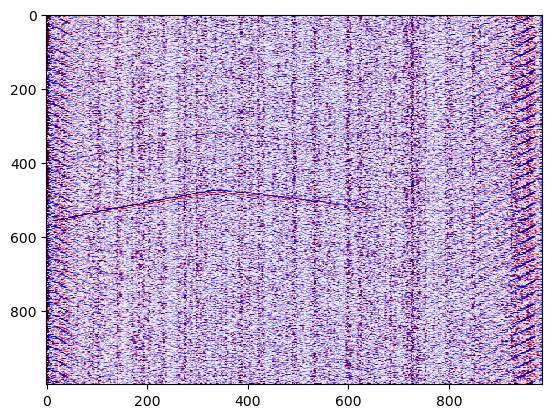

In [7]:
# Plot raw data
plt.imshow(das_data_numpy[:1000,:], cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

In [8]:
# Denoise, as per paper:
denoised_das_data = pretrained_model.denoise_numpy(das_data_numpy)

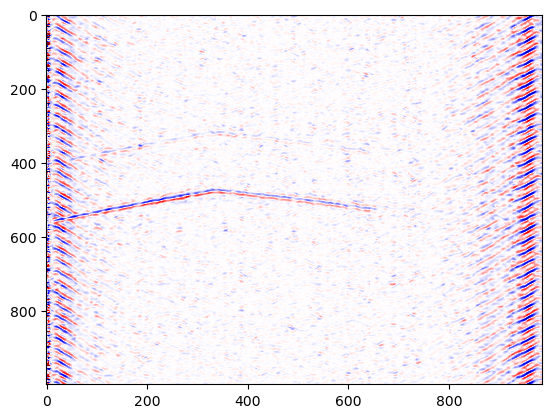

In [9]:
# Plot denoised data
plt.imshow(denoised_das_data[:1000,:], cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

In [10]:
# Denoise but normalise along each DAS channel, rather than across all channels and time points 
# (now recommended to handle relatively high noise channels)
denoised_das_data = pretrained_model.denoise_numpy(das_data_numpy, remove_mean_axis = 0, std_norm_axis = 0)

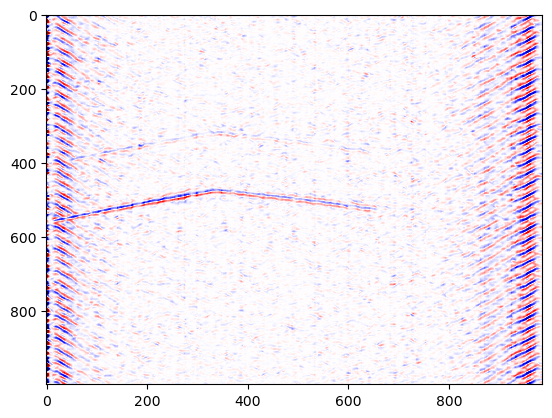

In [11]:
# Plot denoised data
plt.imshow(denoised_das_data[:1000,:], cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

## Training a DAS-N2N model

Required for training a model:
- file_list: List of files containing continuous DAS data (currently only Silixa .tdms files, or .npy files containing DAS data as single large numpy array, are recognised)
- file_dict: Dictionary indicating which DAS channels to use as input data and which to use as target data (see below)
- no_epochs: integer stating how many epochs to train model for (i.e., number of iterations through all available training files)

In [12]:
# Create new model with random weights (or you can load pre-trained weights if you want to do fine-tuning)
model = dasn2n()

In [13]:
import glob
file_list = glob.glob('/Users/sl15218/DAS_data/Line1_triangle/BPT1_UTC_20200117_01*.tdms') # 1 hour of Antarctica training data
file_list += glob.glob('/Users/sl15218/DAS_data/FRS/*.tdms') # Plus data from CaMI FRS boreholes
file_list.sort()


In [14]:
#### LIST CHANNELS TO USE FROM DIFFERENT DATASETS ####
file_dict = {}

# Divide different datasets/arrays into different directories and indicate which channels to use for data in each directory
# Input and target channels are given as a list of tuples, where tuples are (start idx, end idx) for sections of spliced fibre.
# You can give multiple tuples, e.g., for multiple boreholes or different sections of the fibre - see FRS dictionary below

# Antarctica training data
file_dict['Line1_triangle'] = {}    # Create dictionary key for training data directory
file_dict['Line1_triangle']['input_channels'] = [(172,1080)]    # DAS channel idx's for input data (e.g. outgoing fibre)
file_dict['Line1_triangle']['target_channels'] = [(1141,2049)]    # DAS channel idx's for target data (e.g. returning fibre)

# FRS training data
file_dict['FRS'] = {}    # Create dictionary key for training data directory
file_dict['FRS']['input_channels'] = [(830,1165), (1584,1924)]    # DAS channel idx's for input data (e.g. downgoing fibre from two boreholes)
file_dict['FRS']['target_channels'] = [(1165,1500), (1924,2264)]    # DAS channel idx's for target data (e.g. upgoing fibre from two boreholes)

In [15]:
# Training on CPU very slow, so will only run for 1 epoch and a few tdms files:
model.train_model(file_list = file_list[:4],
                  file_dict = file_dict,
                  no_epochs = 1,    # Number of training epochs
                  file_batch_size = 2,    # Number of DAS data files to read in at a time (taken from shuffled list of training files)
                  mini_batch_size = 24,    # Number of 128x96 sections of DAS data to train model on at a time
                  loss = "mae",    # Default is "mse" (mean squared error)
                  init_lr = 1e-4,    # Initial learning rate for model
                  use_scheduler = False,    # Set to True if you wish to anneal learning rate to smaller value (default 1e-6) over course of training
                  remove_mean_axis = 0,    # Axis along which to normalise data before model processing (default is None, i.e. normalise across whole DAS file, as per paper, but channel-wise normalisation recommended to handle high noise channels)
                  std_norm_axis = 0,    # Axis along which to normalise data before model processing (default is None, i.e. normalise across whole DAS file, as per paper, but channel-wise normalisation recommended to handle high noise channels)
                  model_save_dir = "./tmp",   # Directory for saving model weights and loss
                  save_on_epoch_end = False    # Will save model weights and training loss on epoch end
                 )

Epoch:     1 of     1
2024/07/29 11:42:26
File batch:     1 of     2
loss: 0.802229  [    0/ 1888]
loss: 0.797115  [  240/ 1888]
loss: 0.793042  [  480/ 1888]
loss: 0.793630  [  720/ 1888]
loss: 0.796687  [  960/ 1888]
loss: 0.796938  [ 1200/ 1888]
loss: 0.799074  [ 1440/ 1888]
loss: 0.797092  [ 1680/ 1888]
File batch:     2 of     2
loss: 0.795404  [    0/ 1888]
loss: 0.790890  [  240/ 1888]
loss: 0.792172  [  480/ 1888]
loss: 0.792364  [  720/ 1888]
loss: 0.789651  [  960/ 1888]
loss: 0.787067  [ 1200/ 1888]
loss: 0.791257  [ 1440/ 1888]
loss: 0.794929  [ 1680/ 1888]
